In [26]:
import pandas as pd
from shapely.geometry import * 
from cartoframes.auth import Credentials
from cartoframes.data import Dataset
from cartoframes.viz import *
from cartoframes.viz.helpers import *

In [33]:
data = pd.read_pickle('data/target_mn_loc.p')
data = pd.DataFrame([data], index=['geometry']).T.reset_index()
data.rename(columns={'index': 'store_id'}, inplace=True)
data['geometry'] = data['geometry'].apply(lambda x: Point(x[0], x[1]))

In [34]:
data.to_csv('/Users/dfan/Desktop/retail_store_minnesota.csv', index=True)

In [28]:
# Map(Layer(Dataset(data)))

In [24]:
# !pip install cartoframes==1.0b1 --pre

In [1]:
%load_ext autoreload
%autoreload 2

# Travelling Salesman Problem

In [2]:
from src_import.modules import *
from src_import.func import *
plt.style.use('seaborn-poster')

In [3]:
# Load Target Store Location Data in Minnesota

with open('data/target_mn_loc.p', 'rb') as f:
    # type: dict
    # data: {'id': (lng, lat)}
    target_mn_loc = pkl.load(f) 

## Method 1: Christofides Method


```
1. Create a minimum spanning tree T of G.
2. Let O be the set of vertices with odd degree in T. 
3. Find a minimum-weight perfect matching M in the induced subgraph given by the vertices from O.
4. Combine the edges of M and T to form a connected multigraph H in which each vertex has even degree.
5. Form an Eulerian circuit in H.
6. Make the circuit found in previous step into a Hamiltonian circuit by skipping repeated vertices (shortcutting).
```

In [4]:
# reconstruct lat/lng pair (e.g.[[47.209549, -93.527193], [45.052732, -93.365555], ...] ) from `target_mn_loc`
latlng = [list(_[1])[::-1] for _ in target_mn_loc.items()]

# run 100 iterations
n = 100
tests = [christofides(latlng) for _ in range(100)]

# find the shortest path 
# the 7th value (index 6) in each result id `length`  
length = [_[6] for _ in tests]  
tsp_result = tests[np.argmin(length)]

2019-08-27 08:09:08,383 - INFO - [Min] 2075.5577428288625;  [Max] 2677.4999552841973


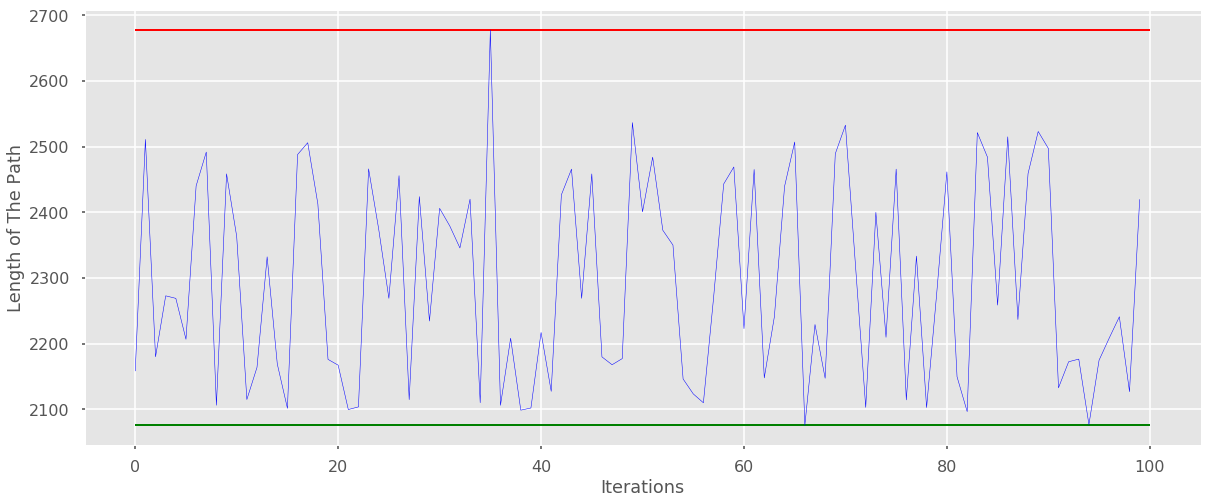

In [5]:
# the following plot shows length of path of each iteration run. 

f, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot([_[6] for _ in tests], color='blue', linewidth=0.5)
ax.hlines(y=min([_[6] for _ in tests]), xmin=0, xmax=100, color='green', linewidth=2)
ax.hlines(y=max([_[6] for _ in tests]), xmin=0, xmax=100, color='red', linewidth=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('Length of The Path');

logging.info(f"[Min] {min([_[6] for _ in tests])};  [Max] {max([_[6] for _ in tests])}")

<font size='5'>
    
**The Following part shows how christofides algorithm works step by step**

### 1. **Complete Graph (G)**

In [8]:
complete_graph = pd.DataFrame([LineString(_) for _ in combinations(list(target_mn_loc.values()), 2)], columns=['geometry'])
Map(Layer(source = Dataset.from_dataframe(complete_graph), 
          style = {'width': 0.2,
                   'color': 'opacity(red, 0.3)'}),
    basemap = basemaps.darkmatter)

### 2. **Minimum Spanning Tree (T)**

In [9]:
minimum_spanning_tree = pd.DataFrame([LineString((list(target_mn_loc.values())[_[0]], list(target_mn_loc.values())[_[1]])) for _ in tsp_result[1]], columns=['geometry'])
Map(layers=[
    Layer(source = Dataset.from_dataframe(complete_graph), 
          style = {'width': 0.5,
                   'color': 'opacity(red, 0.1)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 3})],
    basemap = basemaps.darkmatter)

### 3.1 **Vertices with odd degree (O)**

In [10]:
vertices_odd_degree = pd.DataFrame([Point(list(target_mn_loc.values())[_]) for _ in tsp_result[2]], columns=['geometry'])

Map(layers=[
    Layer(source = Dataset.from_dataframe(complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 3}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    basemap = basemaps.darkmatter)

### 3.2 **Form the subgraph G' of G using only the vertices of O (G')**

In [11]:
sub_complete_graph = pd.DataFrame([LineString(_) for _ in combinations([list(target_mn_loc.values())[i] for i in tsp_result[2]], 2)], columns=['geometry'])
Map(layers=[
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.8,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    basemap = basemaps.darkmatter)

### 5. **Minimum-Weight (perfect) matching M From G' (M)**

In [12]:
min_weight_perfect_matching = pd.DataFrame([LineString((list(target_mn_loc.values())[_[0]], list(target_mn_loc.values())[_[1]])) for _ in tsp_result[3]], columns=['geometry'])

Map(layers=[
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 3,
                   'color': 'opacity(#46aea0, 0.2)'}),
    Layer(source = Dataset.from_dataframe(min_weight_perfect_matching), 
          style = {'width': 3, 
                   'color': 'green'}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    viewport = {'zoom': 8.21, 'lat': 44.967879, 'lng': -93.365291},
    basemap = basemaps.darkmatter)

### 6. **Unite matching and spanning tree T ∪ M to form an Eulerian multigraph (H)**

In [14]:
united_eulerian_multigraph = pd.DataFrame([LineString((list(target_mn_loc.values())[_[0]], list(target_mn_loc.values())[_[1]])) for _ in tsp_result[4]], columns=['geometry'])

Map(layers=[
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset.from_dataframe(united_eulerian_multigraph), 
          style = {'width': 3, 
                   'color': 'darkgreen'}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    basemap = basemaps.darkmatter)

### 7. **Euler Tour (E)**

In [15]:
euler_tour = pd.DataFrame([LineString((list(target_mn_loc.values())[tsp_result[5][i-1]], list(target_mn_loc.values())[tsp_result[5][i]])) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour['order'] = euler_tour.index + 1

euler_tour_origin = pd.DataFrame([Point(list(target_mn_loc.values())[tsp_result[5][i-1]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_origin['order'] = euler_tour_origin.index + 1

euler_tour_dst = pd.DataFrame([Point(list(target_mn_loc.values())[tsp_result[5][i]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_dst['order'] = euler_tour_dst.index + 1

Map(layers=[
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.1)'}),
    Layer(source = Dataset.from_dataframe(united_eulerian_multigraph), 
          style = {'width': 3, 
                   'color': 'opacity(darkgreen, 0.1)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 3,
                   'color': 'opacity(#46aea0, 0.1)'}),
    Layer(source = Dataset.from_dataframe(euler_tour), 
          style = {'width': 3,
                   'color': 'opacity(orange, 0.8)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'}),
    Layer(source = Dataset.from_dataframe(euler_tour_origin), 
          style = {'width': 8,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(euler_tour_dst), 
          style = {'width': 8,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'opacity(yellow, 0.1)'})],
    basemap = basemaps.darkmatter)

### 8. **Shortcutting**

In [16]:
final_route = pd.DataFrame([LineString((list(target_mn_loc.values())[tsp_result[7][i-1]], list(target_mn_loc.values())[tsp_result[7][i]])) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
final_route['order'] = final_route.index + 1

final_tour_origin = pd.DataFrame([Point(list(target_mn_loc.values())[tsp_result[7][i-1]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
final_tour_origin['order'] = final_tour_origin.index + 1

final_tour_dst = pd.DataFrame([Point(list(target_mn_loc.values())[tsp_result[7][i]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
final_tour_dst['order'] = final_tour_dst.index + 1

Map(layers=[
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 1, 
                   'color': 'opacity(yellow, 0.1)'}),
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.1)'}),
    Layer(source = Dataset.from_dataframe(united_eulerian_multigraph), 
          style = {'width': 1, 
                   'color': 'opacity(darkgreen, 0.1)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 1,
                   'color': 'opacity(#46aea0, 0.1)'}),
    Layer(source = Dataset.from_dataframe(euler_tour), 
          style = {'width': 1,
                   'color': 'opacity(orange, 0.1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'}),
    Layer(source = Dataset.from_dataframe(final_tour_origin), 
          style = {'width': 10,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(final_tour_dst), 
          style = {'width': 10,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(final_route), 
          style = {'width': 3,
                   'color': 'opacity(red, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'})],
    basemap = basemaps.darkmatter)


<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>

## Method2: Simulated Annealing

In [17]:
# run 
output = TravelingSalesmanRun(target_mn_loc, 300)
# organize the output
route = result(target_mn_loc, output)
# find the shortest route
shortest_route = shortestRoute(route)

2019-08-27 08:14:06,228 - INFO - [Done] Create A Distance Matrix)
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
2019-08-27 08:14:34,031 - INFO - [1]: 2054618.5670682767 meter route)
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
2019-08-27 08:15:00,443 - INFO - [2]: 2061368.2579342793 meter route)
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
2019-08-27 08:15:26,273 - INFO - [3]: 2043557.3566473853 meter route)
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
2019-08-27 08:15:52,342 - INFO - [4]: 2019980.5193097624 meter route)
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature   

In [21]:
# It will take time to run, we also prepare the precoumpute result.

with open('output/route_SA_300.p', 'rb') as f:
    route = pkl.load(f)
    
with open('output/shortest_route_SA_300.p', 'rb') as f:
    shortest_route = pkl.load(f)

2019-08-27 08:16:28,045 - INFO - [Min] 1996369.784944194;  [Max] 2273096.90986844


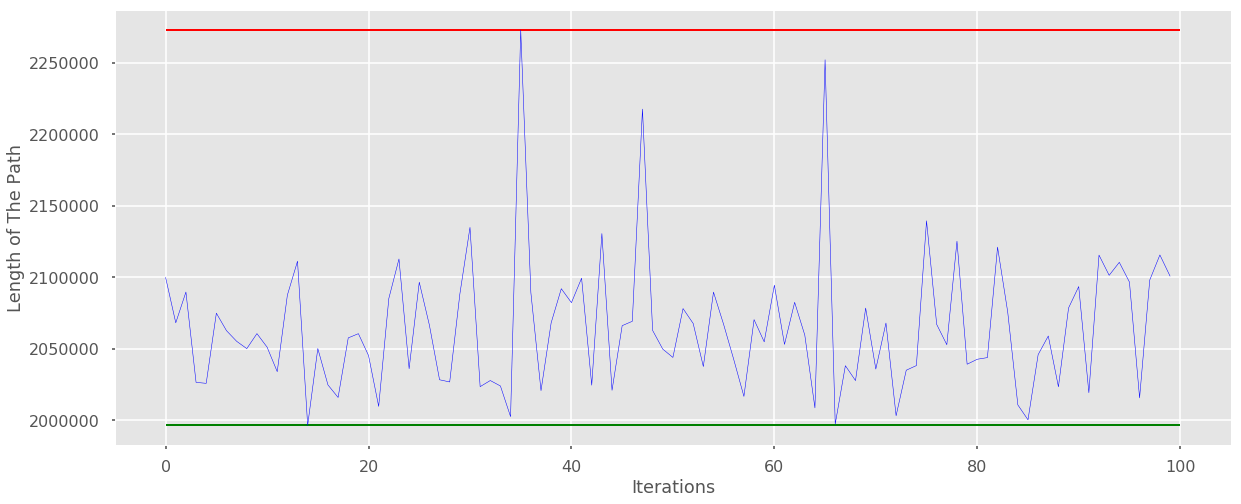

In [23]:
# the following plot shows length of path of each iteration run. 

all_distances = route.drop_duplicates('iteration').sort_values(by='iteration')['distance'].values
random_routes = route.sort_values(by='distance', ascending=False)['iteration'].unique()[:5]
shortest_route = shortest_route.loc[: , ['visitOrder', 'lng', 'lat']]
shortest_route.rename(columns={'visitOrder': 'order'}, inplace=True)

f, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot([_ for _ in all_distances], color='blue', linewidth=0.5)
ax.hlines(y=min([_ for _ in all_distances]), xmin=0, xmax=100, color='green', linewidth=2)
ax.hlines(y=max([_ for _ in all_distances]), xmin=0, xmax=100, color='red', linewidth=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('Length of The Path');

logging.info(f"[Min] {min([_ for _ in all_distances])};  [Max] {max([_ for _ in all_distances])}")

In [24]:
sa_shortest_route = pd.DataFrame([LineString((shortest_route.values[i-1][1:], 
                                              shortest_route.values[i][1:])) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route = sa_shortest_route.append(pd.DataFrame([LineString((shortest_route.values[-1][1:], shortest_route.values[0][1:]))], columns=['geometry']))
sa_shortest_route['order'] = sa_shortest_route.index + 1

sa_shortest_route_origin = pd.DataFrame([Point(shortest_route.values[i-1][1:]) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route_origin = sa_shortest_route_origin.append(pd.DataFrame([Point(shortest_route.values[-1][1:])], columns=['geometry']))
sa_shortest_route_origin['order'] = sa_shortest_route_origin.index + 1

sa_shortest_route_dst = pd.DataFrame([Point(shortest_route.values[i][1:]) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route_dst = sa_shortest_route_dst.append(pd.DataFrame([Point(shortest_route.values[0][1:])], columns=['geometry']))
sa_shortest_route_dst['order'] = sa_shortest_route_dst.index + 1

Map(layers=[
    Layer(source = Dataset.from_dataframe(sa_shortest_route_origin), 
          style = {'width': 10,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(sa_shortest_route_dst), 
          style = {'width': 10,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(sa_shortest_route), 
          style = {'width': 3,
                   'color': 'opacity(red, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'})],
    basemap = basemaps.darkmatter)

<br/><br/><br/><br/>

## Method 3: Ant Colony Optimization

In [ ]:
# alpha: relative importance of pheromone
# beta: relative importance of heuristic information
# rho: pheromone residual coefficient
# q: pheromone intensity
# strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density

aco = ACO(ant_count=200, generations=100, alpha=1.0, beta=10.0, rho=0.75, q=10, strategy=3)

In [26]:
cost_matrix = distance_aco(target_mn_loc)
rank = len(target_mn_loc)
graph = Graph(cost_matrix, rank)
path, cost = aco.solve(graph)
logging.info(f'[Done] Cost: {cost}\nPath: {path}')

2019-08-27 08:18:24,640 - INFO - [Done] Create A Distance Matrix For ACO
2019-08-27 08:18:24,647 - INFO - [Done] Load the Graph
2019-08-27 08:18:26,830 - INFO - [Generation #0] [best cost: 2234269.2064448637]
2019-08-27 08:18:29,240 - INFO - [Generation #1] [best cost: 2210519.822886221]
2019-08-27 08:18:31,544 - INFO - [Generation #2] [best cost: 2158802.1501179775]
2019-08-27 08:18:33,915 - INFO - [Generation #3] [best cost: 2158802.1501179775]
2019-08-27 08:18:36,385 - INFO - [Generation #4] [best cost: 2139529.913301433]
2019-08-27 08:18:38,807 - INFO - [Generation #5] [best cost: 2139529.913301433]
2019-08-27 08:18:41,230 - INFO - [Generation #6] [best cost: 2139529.913301433]
2019-08-27 08:18:43,537 - INFO - [Generation #7] [best cost: 2139529.913301433]
2019-08-27 08:18:46,442 - INFO - [Generation #8] [best cost: 2085149.5091179723]
2019-08-27 08:18:48,224 - INFO - [Generation #9] [best cost: 2085149.5091179723]
2019-08-27 08:18:50,058 - INFO - [Generation #10] [best cost: 20851

In [30]:
loop = path.copy()
loop.append(loop[0])

ac_shortest_route = pd.DataFrame([LineString((list(target_mn_loc.values())[loop[i-1]], list(target_mn_loc.values())[loop[i]])) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route['order'] = ac_shortest_route.index + 1
ac_shortest_route_origin = pd.DataFrame([Point(list(target_mn_loc.values())[loop[i-1]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_origin['order'] = ac_shortest_route_origin.index + 1
ac_shortest_route_dst = pd.DataFrame([Point(list(target_mn_loc.values())[loop[i]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_dst['order'] = ac_shortest_route_dst.index + 1

Map(layers=[
    Layer(source = Dataset.from_dataframe(ac_shortest_route_origin), 
          style = {'width': 10,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(ac_shortest_route_dst), 
          style = {'width': 10,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(ac_shortest_route), 
          style = {'width': 3,
                   'color': 'opacity(red, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'})],
    basemap = basemaps.darkmatter)

<br/><br/><br/>

## Reference

1. 